[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://drive.google.com/file/d/1OlVoRk3ae_8dN3-nGvCMdg2gr2V1-3xX/view?usp=sharing)
# **Anadolu Hayat Emeklilik Datathon 2024**

# **Abstract**

This project, developed as part of a collaborative group effort, aims to predict the type of life insurance product selected by customers using demographic, financial, and behavioral data. Key features include age, gender, profession, income level, and transaction history. An LGBMClassifier model, optimized with custom class weights and stratified cross-validation, was used to handle the dataset’s class imbalance. Predictions were averaged across folds to improve stability.

This approach placed our team **5th** in the **Anadolu Hayat Emeklilik Datathon 2024**, showcasing the effectiveness of boosting algorithms for customer segmentation in life insurance. Further details can be accessed through the project [link](https://www.kaggle.com/competitions/anadolu-hayat-emeklilik-datathon-2024/leaderboard).

# **`1.` Google Drive Mount**

In [1]:
from google.colab import drive

# Try unmounting first if it's already mounted
# !fusermount -u /content/drive

drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# **`2.` Required Libraries**

In [2]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from sklearn.model_selection import StratifiedKFold, StratifiedGroupKFold, train_test_split

from lightgbm import LGBMClassifier
from sklearn.datasets import make_classification
from sklearn.metrics import f1_score, roc_auc_score

from datetime import datetime

# **`3.` Configuration**

In [3]:
seed = 42
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

plt.style.use('ggplot')
rcParams['figure.figsize'] = [10,5]

# **`4.` Load Datasets**

In [4]:
path = "/content/drive/MyDrive/Colab Notebooks/Kaggle/Anadolu Hayat Emeklilik Datathon 2024"
zip_path = os.path.join(path, "anadolu-hayat-emeklilik-datathon-2024.zip")
dir = os.path.join('..', 'ahe')

from zipfile import ZipFile
with ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(dir)

In [5]:
train_raw = pd.read_csv(os.path.join(dir, 'train.csv'))
test_raw = pd.read_csv(os.path.join(dir, 'test.csv'))
sample_submission = pd.read_csv(os.path.join(dir, 'sample_submission.csv'))

In [6]:
train_raw.shape, test_raw.shape

((852719, 97), (195631, 96))

In [7]:
train_raw.head()

,MUSTERI_ID,LABEL,FLAG,PP_CINSIYET,PP_YAS,PP_MESLEK,PP_MUSTERI_SEGMENTI,PP_UYRUK,IL,SORU_YATIRIM_KARAKTERI_CVP,SORU_YATIRIM_KARAKTERI_RG,SORU_MEDENI_HAL_CVP,SORU_MEDENI_HAL_RG,SORU_EGITIM_CVP,SORU_EGITIM_RG,SORU_GELIR_CVP,SORU_GELIR_RG,SORU_COCUK_SAYISI_CVP,SORU_COCUK_SAYISI_RG,BES_AYRILMA_TALEP_ADET,ODEMEME_TALEP_ADET,HAYAT_AYRILMA_TALEP_ADET,BILGI_TALEP_ADET,VADE_TUTAR_0,ODEME_TUTAR_0,VADE_TUTAR_1,ODEME_TUTAR_1,VADE_TUTAR_2,ODEME_TUTAR_2,VADE_TUTAR_3,ODEME_TUTAR_3,VADE_TUTAR_4,ODEME_TUTAR_4,VADE_TUTAR_5,ODEME_TUTAR_5,VADE_TUTAR_6,ODEME_TUTAR_6,VADE_TUTAR_7,ODEME_TUTAR_7,VADE_TUTAR_8,ODEME_TUTAR_8,VADE_TUTAR_9,ODEME_TUTAR_9,VADE_TUTAR_10,ODEME_TUTAR_10,VADE_TUTAR_11,ODEME_TUTAR_11,SON_AY_KATKI_MIKTARI,SON_AY_KATKI_ADET,SON_CEYREK_KATKI_MIKTARI,SON_CEYREK_KATKI_ADET,SON_SENE_KATKI_MIKTARI,SON_SENE_KATKI_ADET,ANAPARA,GETIRI,BU01,BU02,BU03,BU04,BU05,BU06,BU07,BU08,BU09,BU10,BU11,BU12,BU13,BU14,BU15,BU16,BU17,BU18,BU19,BU20,BU21,BU22,BU23,BU24,HU01,HU02,HU03,HU04,HU05,HU06,HU07,HU10,HU11,HU12,HU13,HU14,HU15,HU16,HU17,HU18,HU19,AKTIF_ILK_POLICE_RG
0,61921038d5c39a821cfed2e5e3ad88740decd1fbd6f34b...,UA,HAZIRAN,2,505,Öğretmen,105,1,34,NaN,NaN,Single,68.0,(Diğer),68.0,NaN,NaN,NaN,NaN,0,0,0,0,405,405,405,405,405,405,405,405,405,405,220,220,220,220,220,220,220,220,220,220,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,2654,132,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,9
1,8cd400d3897e5ff130e8e942ee1906d17531a8253d26a4...,UA,HAZIRAN,2,889,Emekli (Sosyal Güvenlik Kurumu Bilinmiyor),102,1,20,NaN,NaN,Married,11.0,İlköğretim,11.0,7500,11.0,NaN,NaN,0,0,0,0,5720,5720,5720,5720,4763,4763,4763,4763,4763,4763,2871,2871,2871,2871,2871,2871,2871,2871,957,957,1914,3828,0,0,NaN,NaN,NaN,NaN,NaN,NaN,62945,75370,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,11
2,6af95ba9ebe2362a0b31b4443fb2405b11d588780c01ad...,HU19,HAZIRAN,2,578,Muhasebe,104,1,6,Yetkin,26.0,Single,235.0,Lisans,235.0,NaN,NaN,0.0,235.0,0,0,0,0,1172,1172,1172,1172,1172,1172,1172,1172,1172,1172,631,631,631,631,631,631,631,631,631,631,631,631,631,631,NaN,NaN,NaN,NaN,NaN,NaN,22929,16055,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,66
3,fe33e7873368d603d2a49a982619e8d61a964d7a0ef68e...,UA,MAYIS,2,648,Diğer,106,1,34,NaN,NaN,Married,111.0,Lise,111.0,1,111.0,0.0,111.0,0,0,0,0,574,0,574,0,574,0,574,0,306,0,306,0,306,0,306,0,306,0,306,0,306,0,306,0,NaN,NaN,NaN,NaN,NaN,NaN,178,497,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,111
4,aae8411e2c335e94922290314abe1fcc81044e8071e1c8...,UA,EYLUL,2,487,İşçi,103,1,77,NaN,NaN,Married,91.0,Lisans,91.0,1500,91.0,0.0,91.0,0,0,0,0,459,0,459,0,459,0,459,459,459,459,459,459,459,0,459,0,248,0,248,0,248,0,248,0,NaN,NaN,NaN,NaN,NaN,NaN,1378,1151,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,90


In [8]:
train_raw.describe()

,PP_CINSIYET,PP_YAS,PP_MUSTERI_SEGMENTI,PP_UYRUK,IL,SORU_YATIRIM_KARAKTERI_RG,SORU_MEDENI_HAL_RG,SORU_EGITIM_RG,SORU_GELIR_RG,SORU_COCUK_SAYISI_CVP,SORU_COCUK_SAYISI_RG,BES_AYRILMA_TALEP_ADET,ODEMEME_TALEP_ADET,HAYAT_AYRILMA_TALEP_ADET,BILGI_TALEP_ADET,VADE_TUTAR_0,ODEME_TUTAR_0,VADE_TUTAR_1,ODEME_TUTAR_1,VADE_TUTAR_2,ODEME_TUTAR_2,VADE_TUTAR_3,ODEME_TUTAR_3,VADE_TUTAR_4,ODEME_TUTAR_4,VADE_TUTAR_5,ODEME_TUTAR_5,VADE_TUTAR_6,ODEME_TUTAR_6,VADE_TUTAR_7,ODEME_TUTAR_7,VADE_TUTAR_8,ODEME_TUTAR_8,VADE_TUTAR_9,ODEME_TUTAR_9,VADE_TUTAR_10,ODEME_TUTAR_10,VADE_TUTAR_11,ODEME_TUTAR_11,SON_AY_KATKI_MIKTARI,SON_AY_KATKI_ADET,SON_CEYREK_KATKI_MIKTARI,SON_CEYREK_KATKI_ADET,SON_SENE_KATKI_MIKTARI,SON_SENE_KATKI_ADET,ANAPARA,GETIRI,BU01,BU02,BU03,BU04,BU05,BU06,BU07,BU08,BU09,BU10,BU11,BU12,BU13,BU14,BU15,BU16,BU17,BU18,BU19,BU20,BU21,BU22,BU23,BU24,HU01,HU02,HU03,HU04,HU05,HU06,HU07,HU10,HU11,HU12,HU13,HU14,HU15,HU16,HU17,HU18,HU19,AKTIF_ILK_POLICE_RG
count,852719.000000,852719.000000,852719.000000,852719.000000,852719.000000,132698.000000,850939.000000,725624.000000,574817.000000,436159.000000,436159.000000,852719.000000,852719.000000,852719.000000,852719.000000,852719.000000,852719.000000,852719.000000,852719.000000,852719.000000,852719.000000,852719.000000,852719.000000,852719.000000,852719.000000,852719.000000,852719.000000,852719.000000,852719.000000,852719.000000,852719.000000,852719.000000,852719.000000,852719.000000,852719.000000,852719.000000,852719.000000,852719.000000,852719.000000,980.000000,980.000000,5620.000000,5620.000000,15006.000000,15006.000000,852719.000000,8.527190e+05,852719.000000,852719.000000,852719.000000,852719.000000,852719.000000,852719.000000,852719.000000,852719.000000,852719.000000,852719.000000,852719.000000,852719.000000,852719.000000,852719.000000,852719.000000,852719.000000,852719.000000,852719.000000,852719.000000,852719.000000,852719.000000,852719.000000,852719.000000,852719.000000,852719.000000,852719.000000,852719.000000,852719.000000,852719.000000,852719.000000,852719.000000,852719.000000,852719.000000,852719.000000,852719.000000,852719.000000,852719.000000,852719.000000,852719.000000,852719.000000,852719.000000,852719.000000
mean,1.494226,440.773115,104.740901,1.007269,31.022318,28.250674,87.329307,84.778107,103.253851,0.112335,141.920219,0.010281,0.000408,0.000569,0.002089,1167.957393,687.891499,895.147545,601.841583,870.184179,595.238552,868.939027,594.898561,756.090768,526.193782,621.828441,437.912835,587.456773,411.157705,520.239067,367.928009,474.581990,335.411839,437.400763,306.716417,416.588563,291.900822,406.869434,283.587381,675.524490,1.065306,4077.132562,1.718327,7045.616953,2.837598,17413.149898,3.279004e+04,0.046230,0.093469,0.006851,0.000719,0.000331,0.000004,0.005290,0.098274,0.173885,0.043963,0.079270,0.000011,0.048544,0.000335,0.000976,0.120004,0.199575,0.009123,0.050061,0.024958,0.004277,0.001089,0.180737,0.029874,0.000304,0.000019,0.000756,0.010947,0.009053,0.016257,0.006626,0.005217,0.002355,0.000950,0.000100,0.020374,0.000770,0.000402,0.012570,0.019923,0.006856,62.937123
std,0.499967,205.058165,1.425773,0.107100,18.434540,11.966714,69.144079,71.030740,63.343308,4.568026,51.963410,0.114947,0.023573,0.027240,0.087839,4294.029997,3201.321654,1296.980403,1203.734769,1250.228654,1175.512140,1264.731995,1169.151019,1135.880375,1073.709956,975.824602,926.889169,1012.085053,934.960770,847.263775,811.048254,770.281077,731.296987,728.158681,685.654602,668.824418,642.134642,705.809218,656.317911,5284.490182,0.421366,11775.604867,3.343935,16583.438009,6.062417,39168.960560,1.092315e+05,0.211568,0.305716,0.085503,0.028042,0.019369,0.001876,0.076276,0.319002,0.448594,0.217589,0.314787,0.003249,0.246594,0.021052,0.032832,0.369783,0.462798,0.100228,0.268920,0.163226,0.068004,0.034822,0.401379,0.177609,0.027798,0.004332,0.035199,0.104348,0.133881,0.142993,0.081129,0.078119,0.053899,0.033259,0.009984,0.151613,0.027789,0.021355,0.164277,0.140382,0.100845,56.455928
min,1.000000,0.000000,101.000000,1.

- **Distribution Analysis**

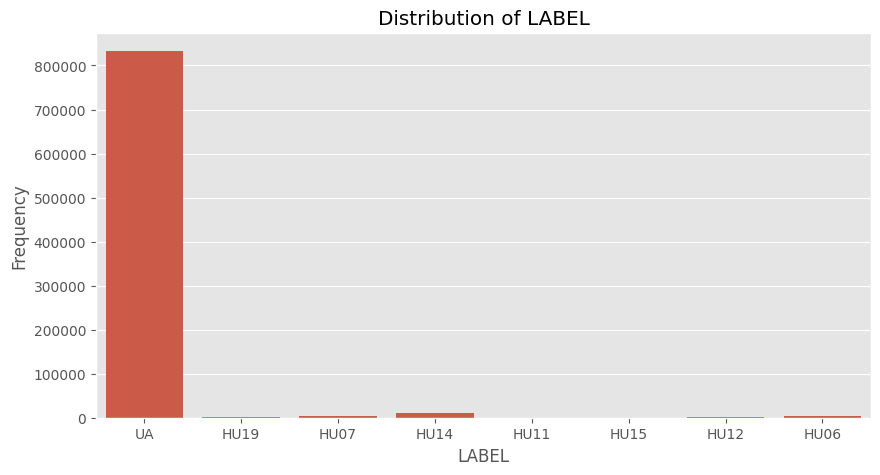

In [9]:
# Distribution of the target variable
target = 'LABEL'
sns.countplot(data=train_raw, x=target)
plt.title(f'Distribution of {target}')
plt.xlabel(target)
plt.ylabel('Frequency')
plt.show()

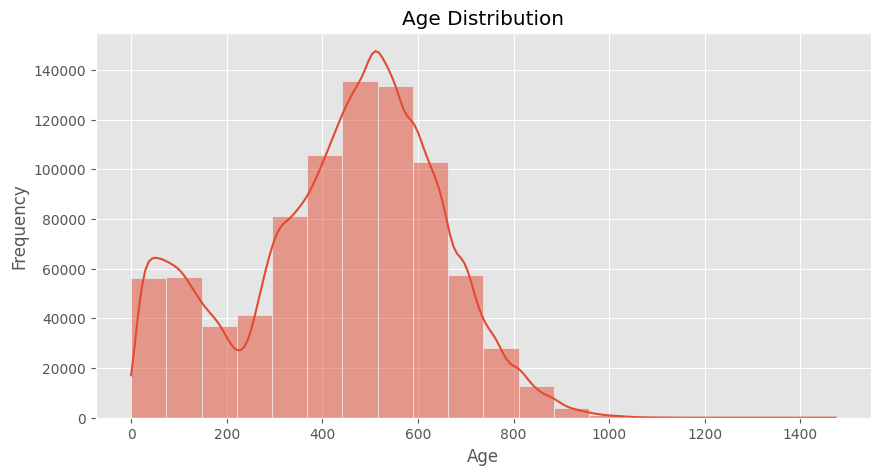

In [10]:
# Visualizing age distribution
sns.histplot(train_raw['PP_YAS'], bins=20, kde=True)
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()


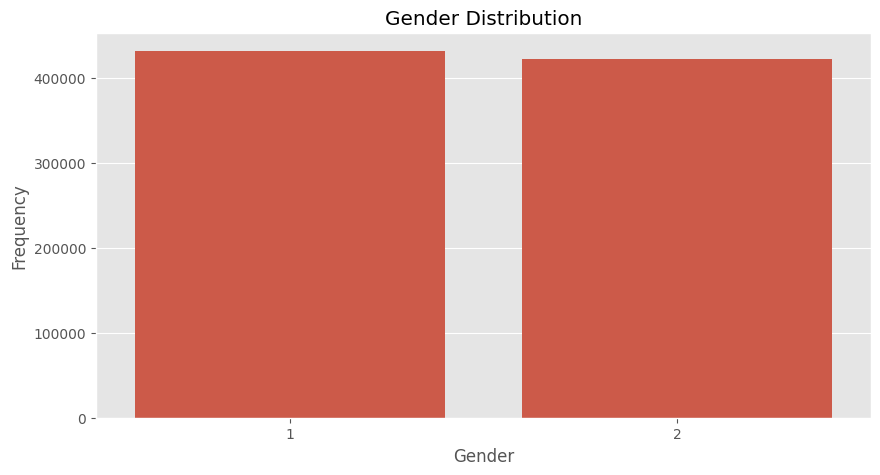

In [11]:
# Distribution of genders
sns.countplot(data=train_raw, x='PP_CINSIYET')
plt.title('Gender Distribution')
plt.xlabel('Gender')
plt.ylabel('Frequency')
plt.show()

# **`5.` Preprocessing**

In [60]:
# Categorize features as categorical or numerical
def cat_num_features(df):
    cat_features = df.select_dtypes(include=['object', 'category']).columns.tolist()
    num_features = df.select_dtypes(exclude=['object', 'category']).columns.tolist()
    return cat_features, num_features

cat_features, num_features = cat_num_features(train_raw)
print(cat_features)

['MUSTERI_ID', 'LABEL', 'FLAG', 'PP_MESLEK', 'SORU_YATIRIM_KARAKTERI_CVP', 'SORU_MEDENI_HAL_CVP', 'SORU_EGITIM_CVP', 'SORU_GELIR_CVP']


In [43]:
# Display columns with missing values
missing_columns = train_raw.isna().sum()[train_raw.isna().sum() > 0]
print(missing_columns)

PP_MESLEK                      88620
SORU_YATIRIM_KARAKTERI_CVP    720021
SORU_YATIRIM_KARAKTERI_RG     720021
SORU_MEDENI_HAL_CVP             1780
SORU_MEDENI_HAL_RG              1780
SORU_EGITIM_CVP               127095
SORU_EGITIM_RG                127095
SORU_GELIR_CVP                277902
SORU_GELIR_RG                 277902
SORU_COCUK_SAYISI_CVP         416560
SORU_COCUK_SAYISI_RG          416560
SON_AY_KATKI_MIKTARI          851739
SON_AY_KATKI_ADET             851739
SON_CEYREK_KATKI_MIKTARI      847099
SON_CEYREK_KATKI_ADET         847099
SON_SENE_KATKI_MIKTARI        837713
SON_SENE_KATKI_ADET           837713
dtype: int64


In [44]:
# Convert 'SORU_GELIR_CVP' to numeric, handling errors by coercion, setting errors to NaN
train_raw['SORU_GELIR_CVP'] = pd.to_numeric(train_raw['SORU_GELIR_CVP'], errors='coerce')
train_raw['SORU_GELIR_CVP'] = pd.to_numeric(train_raw['SORU_GELIR_CVP'], errors='coerce')

# Drop columns with the most missing values and specific columns
drop_cols = train_raw.isna().sum().sort_values(ascending=False).head(14).index.to_list() + ['MUSTERI_ID', 'SORU_MEDENI_HAL_RG']
drop_cols.remove('SORU_EGITIM_CVP') if 'SORU_EGITIM_CVP' in drop_cols else None

train = train_raw.drop(columns=drop_cols)
test = test_raw.drop(columns=drop_cols)

# Encode target labels
labels = list(train[target].unique())
# ['UA', 'HU19', 'HU07', 'HU14', 'HU11', 'HU15', 'HU12', 'HU06']

label_encoder = LabelEncoder()
train['LABEL'] = label_encoder.fit_transform(train['LABEL'])

In [11]:
# Display columns with missing values
missing_columns = train.isna().sum()[train.isna().sum() > 0]
print(missing_columns)

PP_MESLEK               88620
SORU_MEDENI_HAL_CVP      1780
SORU_EGITIM_CVP        127095
dtype: int64


In [12]:
# Encode categorical variables
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
categorical_cols, _ = cat_num_features(train)
encoder.fit(train[categorical_cols])
train[categorical_cols] = encoder.transform(train[categorical_cols])
test[categorical_cols] = encoder.transform(test[categorical_cols])

# One-hot encode selected categorical columns
train = pd.get_dummies(train, columns=['PP_CINSIYET', 'PP_MUSTERI_SEGMENTI'])
test = pd.get_dummies(test, columns=['PP_CINSIYET', 'PP_MUSTERI_SEGMENTI'])

# Define features and target
X = train.drop(columns=['LABEL'])
y = train['LABEL']

# **`6.` Model & Prediction**

In [ ]:
# Class weights
class_weights = {0: 0.5,
                 1: 0.5,
                 2: 2,
                 3: 2,
                 4: 0.5,
                 5: 2,
                 6: 2,
                 7: 0.05}
best_params_lgbm = {
    'class_weight': class_weights,
    'verbose' : -1,
    "boosting_type": "dart",
    "random_state": seed,
    'learning_rate': 0.05,
    'n_estimators': 500,
    }


In [ ]:
start_time = datetime.now()

# Define the labels and group for StratifiedGroupKFold
labels = [0, 1, 2, 3, 4, 5, 6, 7]
groups = np.array(train['AKTIF_ILK_POLICE_RG'])

# Initialize model and lists to store scores
model = LGBMClassifier(**best_params_lgbm)
weighted_f1_scores = []
weighted_f1_scores_worse = []
test_preds = []

# Calculate frequency-based weights for each class
frequencies = y.value_counts()
inverse_frequencies = 1 / frequencies
weights = inverse_frequencies / inverse_frequencies.sum()

# Stratified Group K-Fold cross-validation
gkf = StratifiedGroupKFold(n_splits=3, shuffle=True, random_state=seed)

for fold, (train_index, val_index) in enumerate(gkf.split(X, y, groups), 1):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    # Optional: Print distribution of 'FLAG' in train and validation sets
    for flag in [4, 3, 5, 0, 2, 1]:
        print(f'FLAG {flag} - Train: {X_train[X_train["FLAG"]==flag].shape[0]}, Val: {X_val[X_val["FLAG"]==flag].shape[0]}')

    # Train model
    model.fit(X_train, y_train)

    # Make predictions on validation and test sets
    y_pred = model.predict(X_val)
    y_pred_test = model.predict_proba(test)
    test_preds.append(y_pred_test)

    # Calculate F1 score for each class
    f1_scores = f1_score(y_val, y_pred, average=None, labels=labels)

    # Weighted F1 score for specific target classes
    score_worse = (weights[[2, 3, 5, 6]] * [f1_scores[i] for i in [2, 3, 5, 6]]).sum()
    weighted_f1_scores_worse.append(score_worse)
    print(f'Fold {fold}: Weighted F1 Score worse = {score_worse:.4f}')


    # Weighted F1 score for all classes
    score = (weights[labels] * f1_scores).sum()
    weighted_f1_scores.append(score)
    print(f'Fold {fold}: Weighted F1 Score = {score:.4f}')

# Calculate average weighted F1 score across folds
average_weighted_f1_score_worse = np.mean(weighted_f1_scores_worse)
print(f'\nAverage Weighted F1 Score worse across all folds: {average_weighted_f1_score_worse:.4f}')
average_weighted_f1_score = np.mean(weighted_f1_scores)
print(f'\nAverage Weighted F1 Score across all folds: {average_weighted_f1_score:.4f}')

# Print duration of execution
end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))


FLAG 4 - Train: 169271, Val: 77118
FLAG 3 - Train: 172977, Val: 79216
FLAG 5 - Train: 59783, Val: 26677
FLAG 0 - Train: 57763, Val: 26978
FLAG 2 - Train: 60957, Val: 28213
FLAG 1 - Train: 63933, Val: 29833
Fold 1: Weighted F1 Score worse = 0.2497
Fold 1: Weighted F1 Score = 0.2608
FLAG 4 - Train: 156525, Val: 89864
FLAG 3 - Train: 162055, Val: 90138
FLAG 5 - Train: 55819, Val: 30641
FLAG 0 - Train: 54819, Val: 29922
FLAG 2 - Train: 57343, Val: 31827
FLAG 1 - Train: 61991, Val: 31775
Fold 2: Weighted F1 Score worse = 0.2307
Fold 2: Weighted F1 Score = 0.2519
FLAG 4 - Train: 166982, Val: 79407
FLAG 3 - Train: 169354, Val: 82839
FLAG 5 - Train: 57318, Val: 29142
FLAG 0 - Train: 56900, Val: 27841
FLAG 2 - Train: 60040, Val: 29130
FLAG 1 - Train: 61608, Val: 32158
Fold 3: Weighted F1 Score worse = 0.2151
Fold 3: Weighted F1 Score = 0.2328

Average Weighted F1 Score worse across all folds: 0.2318

Average Weighted F1 Score across all folds: 0.2485
Duration: 3:16:39.761526


# **`7.` Submission**

In [ ]:
def save_predictions(test_preds, label_encoder, sample_submission, output_path='/kaggle/working/submission.csv'):
    # Take the mean of the test predictions across folds and find the class with the highest probability
    predictions = np.argmax(np.mean(test_preds, axis=0), axis=1)

    # Convert numeric predictions back to original labels
    predictions = label_encoder.inverse_transform(predictions)

    # Print frequency of each predicted label
    print("Prediction frequencies:\n", pd.Series(predictions).value_counts().sort_index())

    # Add predictions to the sample submission file and save
    sample_submission[target] = predictions
    sample_submission.to_csv(output_path, index=False)
    print(f"Predictions saved to {output_path}")

save_predictions(test_preds, label_encoder, sample_submission, output_path="submission.csv")


Prediction frequencies:
 HU06       419
HU07      2019
HU11       143
HU12       696
HU14      6054
HU15        60
HU19      1010
UA      185230
Name: count, dtype: int64
Predictions saved to submission.csv


# **`8.` Conclusion**

The model effectively identified life insurance products by leveraging diverse customer data. Key drivers included demographic information and transaction behavior, highlighting their importance in predicting customer preferences. This project demonstrates the potential of machine learning in enhancing customer targeting strategies in the insurance sector. Future work could explore additional feature engineering and weight optimization to further improve predictive accuracy.